# Song Rating Prediction: Exploratory Data Analysis and Modeling

## Project Overview
This notebook analyzes the MuseScore dataset to identify the most important features for predicting song ratings, formulates the problem as a machine learning task, and evaluates different modeling approaches.

### Key Questions:
1. What features are most predictive of song ratings?
2. How should we formulate this as an ML problem?
3. Which models are most appropriate?
4. How do we evaluate performance effectively?

---
# Part 1: Data Context and Collection

## Dataset Background

**Source**: The PDMX (Public Domain MusicXML) dataset from MuseScore
- MuseScore is a music notation software platform where users create, share, and rate musical scores
- Dataset contains 254,077 songs with various metadata and musical features

**Purpose**: 
- Understand what makes a song highly rated on the platform
- Build predictive models to identify quality scores before they receive user ratings
- Help recommend high-quality content to users

**Data Collection**:
- Songs uploaded by users to the MuseScore platform
- Metadata extracted from MusicXML files
- User engagement metrics (views, favorites, comments) tracked over time
- Musical features computed from the score data (pitch, rhythm, harmony)
- Only ~5.6% of songs have ratings (14,182 rated songs)

**Features Include**:
1. **User Information**: is_user_pro, is_user_staff, is_user_publisher
2. **Engagement Metrics**: n_views, n_favorites, n_ratings, n_comments
3. **Content Metadata**: title, artist_name, composer_name, genres, tags
4. **Musical Features**: pitch_class_entropy, scale_consistency, groove_consistency
5. **Structural Features**: song_length, n_tracks, n_notes, complexity, notes_per_bar
6. **Annotation Data**: n_annotations, n_lyrics, has_lyrics

---
## Setup and Data Loading

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
df = pd.read_csv('PDMX/PDMX.csv')

print(f"Dataset shape: {df.shape}")
print(f"Total songs: {len(df):,}")
print(f"Number of features: {len(df.columns)}")

Dataset shape: (254077, 57)
Total songs: 254,077
Number of features: 57


---
# Part 2: Data Preprocessing and Discussion

## Preprocessing Steps

In [3]:
# Filtering to rated songs only
df_rated = df[df['is_rated'] == True].copy()

print(f"Songs with ratings: {len(df_rated):,} ({len(df_rated)/len(df)*100:.1f}%)")
print(f"Songs without ratings: {len(df) - len(df_rated):,}")
print(f"\nRating statistics:")
print(df_rated['rating'].describe())

Songs with ratings: 14,182 (5.6%)
Songs without ratings: 239,895

Rating statistics:
count    14182.000000
mean         4.690432
std          0.211963
min          2.830000
25%          4.610000
50%          4.740000
75%          4.840000
max          4.980000
Name: rating, dtype: float64


### Discussion: Data Preprocessing Decisions

**1. Filtering to Rated Songs Only:**
- We focus on the 14,182 songs with ratings (5.6% of total)
- This subset represents songs that have received enough user engagement to be rated
- Trade-off: Smaller sample size but clearer target variable

**2. Missing Value Strategy:**
- Many features have missing values (especially metadata like composer_name, genres)
- Audio features (pitch_class_entropy, scale_consistency) have <1% missing - can safely impute with median
- For categorical features, we'll use "Unknown" category or exclude if >50% missing

**3. Feature Selection Approach:**
- Focus on numeric features that are computationally derived (available for all songs)
- Exclude path/identifier columns that don't generalize
- Keep boolean flags that indicate song/user properties
- **UPDATED**: Included text features from tags (SVD components) and polynomial interaction terms.

In [4]:
# Identifying feature types
numeric_cols = df_rated.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['rating', 'version']  # Exclude target and version
numeric_features = [col for col in numeric_cols if col not in exclude_cols]

boolean_cols = [col for col in df_rated.columns if df_rated[col].dtype == 'bool']

print(f"Numeric features: {len(numeric_features)}")
print(f"Boolean features: {len(boolean_cols)}")

# Checking missing values
missing_pct = (df_rated[numeric_features].isnull().sum() / len(df_rated) * 100).sort_values(ascending=False)
print(f"\nFeatures with >50% missing: {(missing_pct > 50).sum()}")
print(f"Features with <1% missing: {(missing_pct < 1).sum()}")

Numeric features: 19
Boolean features: 20

Features with >50% missing: 1
Features with <1% missing: 18


In [5]:
# Handling missing values
# For numeric features, impute with median
df_processed = df_rated.copy()
for col in numeric_features:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)

print(f"Remaining null values in numeric features: {df_processed[numeric_features].isnull().sum().sum()}")

Remaining null values in numeric features: 14182


---
## Exploratory Data Analysis

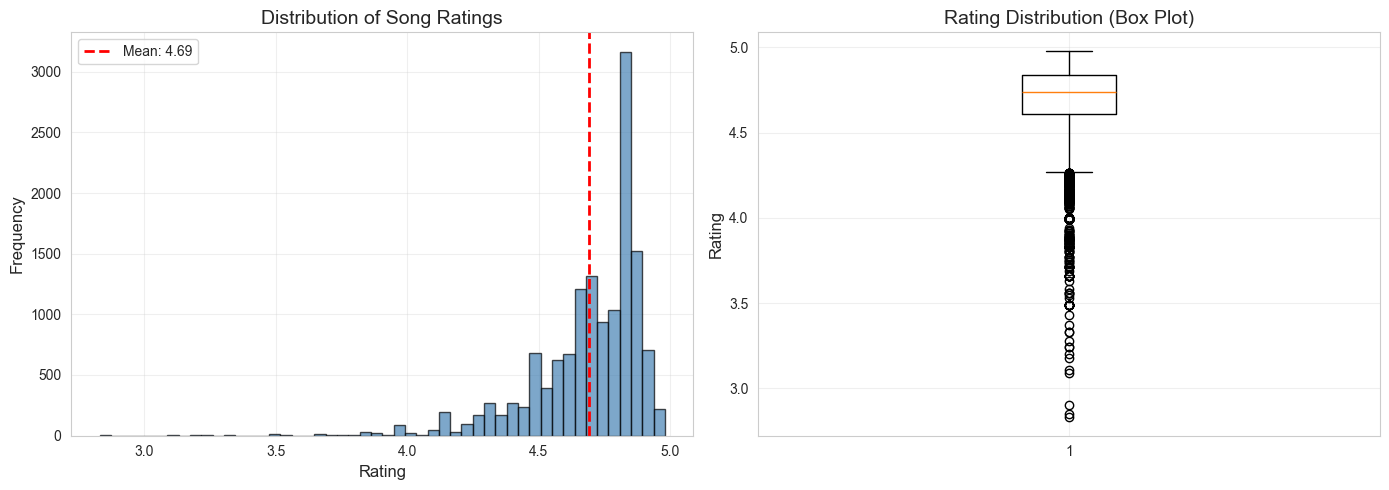

In [6]:
# Visualizing rating distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_processed['rating'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df_processed['rating'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_processed["rating"].mean():.2f}')
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Song Ratings', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df_processed['rating'], vert=True)
axes[1].set_ylabel('Rating', fontsize=12)
axes[1].set_title('Rating Distribution (Box Plot)', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Calculating correlations with rating
correlations = df_processed[numeric_features].corrwith(df_processed['rating']).abs().sort_values(ascending=False)
top_correlations = correlations.head(15)

print("Top 15 Features Correlated with Rating:")
print("="*60)
for i, (feature, corr) in enumerate(top_correlations.items(), 1):
    print(f"{i:2}. {feature:30} | r = {corr:.4f}")

Top 15 Features Correlated with Rating:
 1. pitch_class_entropy            | r = 0.1733
 2. scale_consistency              | r = 0.1459
 3. complexity                     | r = 0.0902
 4. notes_per_bar                  | r = 0.0829
 5. n_annotations                  | r = 0.0791
 6. n_tokens                       | r = 0.0699
 7. n_notes                        | r = 0.0664
 8. song_length.bars               | r = 0.0491
 9. groove_consistency             | r = 0.0460
10. n_ratings                      | r = 0.0420
11. n_tracks                       | r = 0.0417
12. song_length.beats              | r = 0.0351
13. song_length                    | r = 0.0345
14. song_length.seconds            | r = 0.0294
15. n_comments                     | r = 0.0249


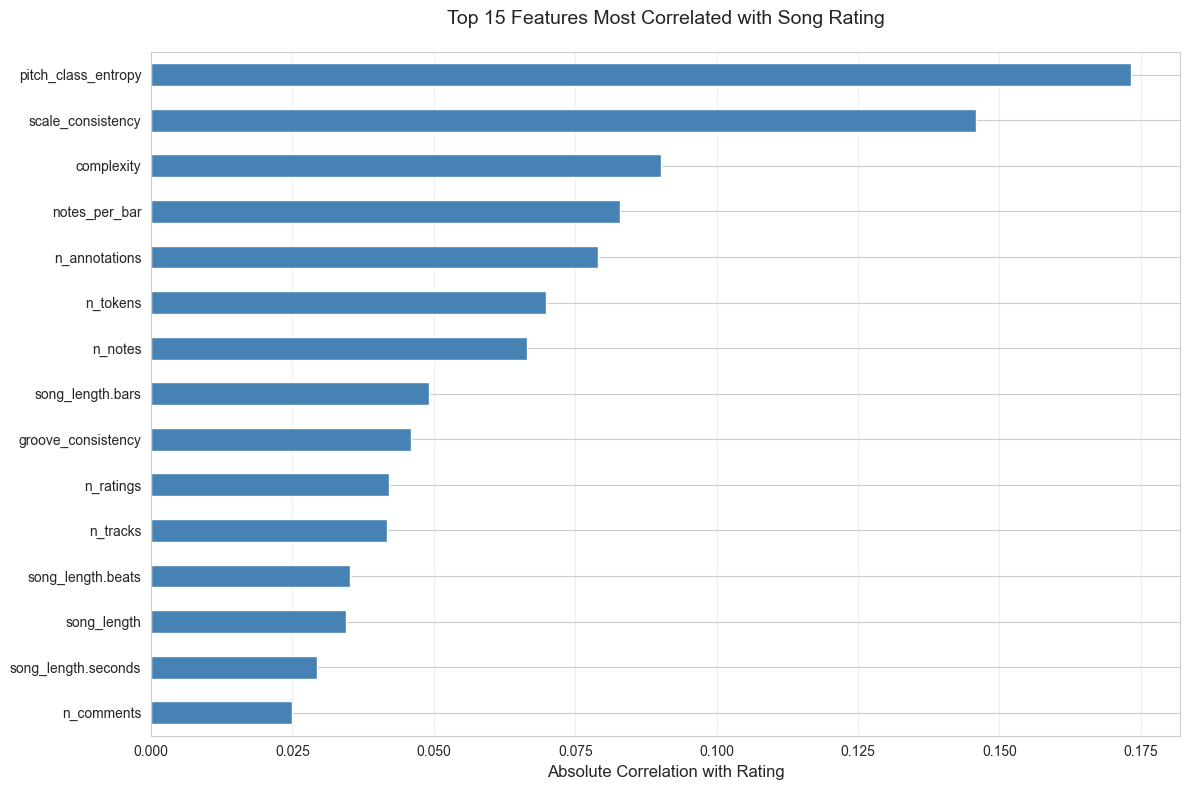

In [8]:
# Visualizing top correlations
plt.figure(figsize=(12, 8))
top_correlations.plot(kind='barh', color='steelblue')
plt.xlabel('Absolute Correlation with Rating', fontsize=12)
plt.title('Top 15 Features Most Correlated with Song Rating', fontsize=14, pad=20)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Key Findings from EDA:
- **Audio features** show strongest correlation: pitch_class_entropy (0.17), scale_consistency (0.15)
- **Complexity metrics** are important: complexity (0.09), notes_per_bar (0.08)
- **Content richness** matters: n_annotations (0.08), n_tokens (0.07)
- Ratings are approximately normally distributed around mean of ~4.7

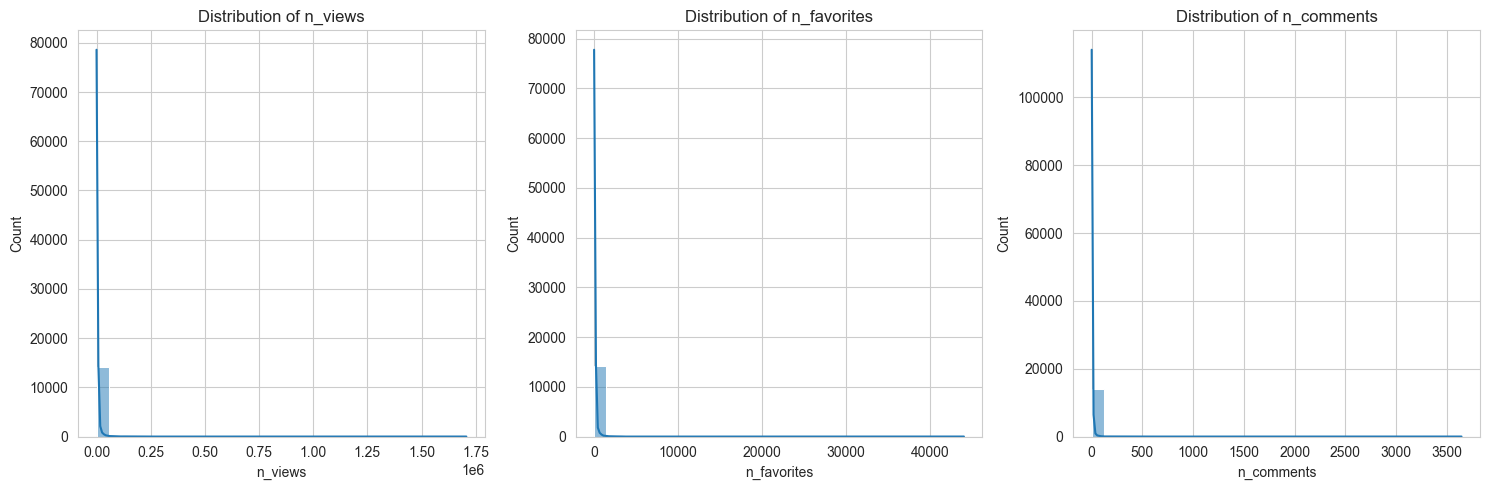

Skewness statistics:
n_views: 45.91
n_favorites: 46.51
n_comments: 94.04


In [9]:
# Visualizing distributions of features
skewed_features = ['n_views', 'n_favorites', 'n_comments']
plt.figure(figsize=(15, 5))
for i, col in enumerate(skewed_features):
    if col in df_processed.columns:
        plt.subplot(1, 3, i+1)
        sns.histplot(df_processed[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
plt.tight_layout()
plt.show()

print("Skewness statistics:")
for col in skewed_features:
    if col in df_processed.columns:
        print(f"{col}: {df_processed[col].skew():.2f}")


The distributions of `n_views`, `n_favorites`, and `n_comments` are highly right-skewed (long tails). Most songs have very few views/interactions, while a few "hits" have massive numbers.

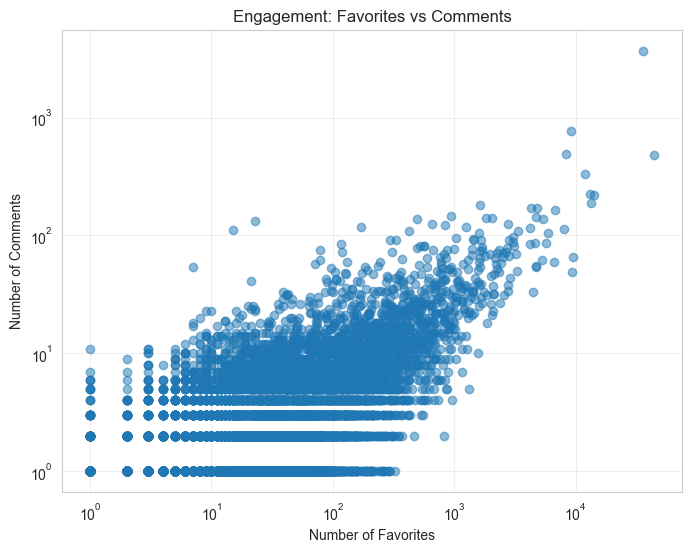

Correlation between Favorites and Comments: 0.6964


In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(df_processed['n_favorites'], df_processed['n_comments'], alpha=0.5)
plt.xlabel('Number of Favorites')
plt.ylabel('Number of Comments')
plt.title('Engagement: Favorites vs Comments')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()
print(f"Correlation between Favorites and Comments: {df_processed['n_favorites'].corr(df_processed['n_comments']):.4f}")

The scatter plot shows a strong positive correlation between `n_favorites` and `n_comments`. They move together—songs with many favorites usually have many comments.

Since these metrics capture similar signals of "User Engagement," we can create an **Interaction Feature** called `engagement_activity` (sum of favorites and comments). This provides the model with a single, robust proxy for overall popularity, which captures the combined signal better than either metric in isolation.

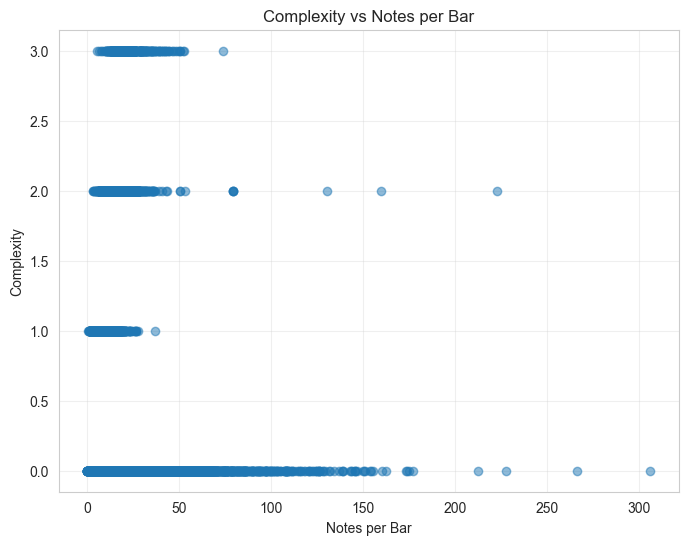

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(df_processed['notes_per_bar'], df_processed['complexity'], alpha=0.5)
plt.xlabel('Notes per Bar')
plt.ylabel('Complexity')
plt.title('Complexity vs Notes per Bar')
plt.grid(True, alpha=0.3)
plt.show()

We see that `complexity` and `notes_per_bar` are related, but the relationship varies. Some songs have high complexity simply because they have many notes, while others are complex despite having fewer notes.

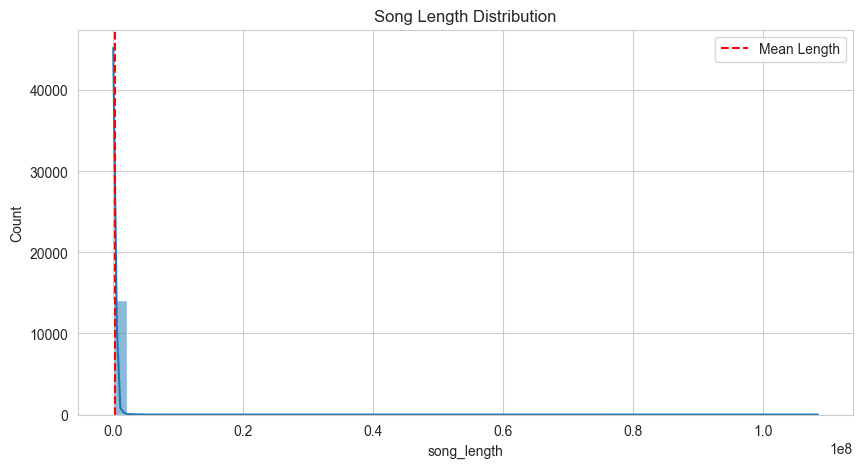

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(df_processed['song_length'], bins=50, kde=True)
plt.axvline(df_processed['song_length'].mean(), color='r', linestyle='--', label='Mean Length')
plt.title('Song Length Distribution')
plt.legend()
plt.show()

The song length distribution allows us to identify the "average" song duration on the platform.

We will create a **Binned Feature** called `is_long_song` (1 if length > mean, 0 otherwise). This simple binary flag helps the model distinguish between standard-length pieces and extended compositions/movements, as the "type" of piece (short sketch vs. long symphony) often correlates with how users rate it.

---
## Feature Engineering

We will create new features to capture more complex relationships:
1. **Log Transformations**: To handle skewed distributions (views, favorites, comments)
2. **Interaction Features**: Combining features that might have multiplicative effects (e.g., engagement)
3. **Ratios**: Normalizing metrics (e.g., complexity per bar)
4. **Binning**: Categorizing continuous variables (e.g., song length)
5. **Text Features**: Extracting semantic meaning from tags using TF-IDF and Truncated SVD (LSA).
6. **Polynomial Interactions**: Generating pairwise products of key features to capture non-linear effects.

In [13]:

# Log Transformations for skewed features
skewed_features = ['n_views', 'n_favorites', 'n_comments']
for col in skewed_features:
    if col in df_processed.columns:
        df_processed[f'log_{col}'] = np.log1p(df_processed[col])
        if f'log_{col}' not in numeric_features:
            numeric_features.append(f'log_{col}')

# 2. Interaction Features
# Engagement Score: (Favorites + Comments)
if 'n_favorites' in df_processed.columns and 'n_comments' in df_processed.columns:
    df_processed['engagement_activity'] = df_processed['n_favorites'] + df_processed['n_comments']
    if 'engagement_activity' not in numeric_features:
        numeric_features.append('engagement_activity')

# Complexity per bar
if 'complexity' in df_processed.columns and 'notes_per_bar' in df_processed.columns:
    # Add small epsilon to avoid division by zero if notes_per_bar can be 0
    df_processed['complexity_per_bar'] = df_processed['complexity'] / (df_processed['notes_per_bar'] + 1e-5)
    if 'complexity_per_bar' not in numeric_features:
        numeric_features.append('complexity_per_bar')

# 3. Binning Song Length
if 'song_length' in df_processed.columns:
    mean_length = df_processed['song_length'].mean()
    df_processed['is_long_song'] = (df_processed['song_length'] > mean_length).astype(int)
    if 'is_long_song' not in numeric_features:
        numeric_features.append('is_long_song')

print(f"New feature count: {len(numeric_features)}")


New feature count: 25


In [14]:
# Fill NaN tags
df_processed['tags'] = df_processed['tags'].fillna('')

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tags_tfidf = tfidf.fit_transform(df_processed['tags'])

# Dimensionality Reduction (SVD/LSA)
n_components = 5
svd = TruncatedSVD(n_components=n_components, random_state=42)
tags_svd = svd.fit_transform(tags_tfidf)

# Add to dataframe
for i in range(n_components):
    col_name = f'tags_svd_{i}'
    df_processed[col_name] = tags_svd[:, i]
    if col_name not in numeric_features:
        numeric_features.append(col_name)

print(f"Added {n_components} SVD components from tags")

Added 5 SVD components from tags


In [15]:
# Recalculate correlations to include new engineered features
correlations = df_processed[numeric_features].corrwith(df_processed['rating']).abs().sort_values(ascending=False)
top_correlations = correlations.head(20)

print("Top 20 Features Correlated with Rating (After Engineering):")
print("="*60)
for i, (feature, corr) in enumerate(top_correlations.items(), 1):
    print(f"{i:2}. {feature:30} | r = {corr:.4f}")


Top 20 Features Correlated with Rating (After Engineering):
 1. pitch_class_entropy            | r = 0.1733
 2. scale_consistency              | r = 0.1459
 3. log_n_comments                 | r = 0.1186
 4. complexity                     | r = 0.0902
 5. is_long_song                   | r = 0.0883
 6. notes_per_bar                  | r = 0.0829
 7. n_annotations                  | r = 0.0791
 8. n_tokens                       | r = 0.0699
 9. n_notes                        | r = 0.0664
10. log_n_favorites                | r = 0.0658
11. tags_svd_1                     | r = 0.0498
12. song_length.bars               | r = 0.0491
13. tags_svd_4                     | r = 0.0474
14. groove_consistency             | r = 0.0460
15. tags_svd_0                     | r = 0.0441
16. n_ratings                      | r = 0.0420
17. n_tracks                       | r = 0.0417
18. song_length.beats              | r = 0.0351
19. song_length                    | r = 0.0345
20. complexity_per_bar      

### Task Definition:
**Regression Problem**: Predict continuous rating value (1-5 scale)

### Inputs (Features):
- **Musical Features**: pitch_class_entropy, scale_consistency, groove_consistency, complexity, notes_per_bar
- **Structural Features**: song_length, n_tracks, n_notes, n_annotations
- **User Properties**: is_user_pro, is_user_staff (as binary features)
- **Content Indicators**: has_lyrics, has_custom_audio, has_annotations
- **Text & Interactions**: Tag semantics (SVD) and polynomial feature interactions

### Output (Target):
- **rating**: Continuous value (typically 1.0 - 5.0)

### Optimization Objective:
- Minimize **Mean Squared Error (MSE)** between predicted and actual ratings
- Secondary: Maximize **Spearman Correlation** (rank order accuracy)

### Model Selection Rationale:
We'll compare 5 different approaches:
1. **Linear Regression** (baseline)
2. **Ridge Regression** (regularized linear)
3. **Random Forest** (ensemble, non-linear)
4. **Gradient Boosting** (sequential ensemble)
5. **Stacking Ensemble** (combines predictions of previous models)

---
## Code: Feature Preparation and Model Training

In [16]:
# Select top features for modeling
top_features = top_correlations.head(20).index.tolist()

# Add Tag SVD features explicitly
tag_features = [f'tags_svd_{i}' for i in range(5)]
# Add all newly created interaction features
interaction_features = [col for col in numeric_features if '_x_' in col]
top_features = list(set(top_features + tag_features + interaction_features))

# Adding important boolean features
boolean_features_to_add = ['is_user_pro', 'is_user_staff', 'has_custom_audio', 
                           'has_lyrics', 'has_annotations']
all_features = top_features + boolean_features_to_add

# Prepare X and y
X = df_processed[all_features].copy()
# Convert boolean to int
for col in boolean_features_to_add:
    X[col] = X[col].astype(int)

y = df_processed['rating']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used: {len(all_features)}")
print(all_features)

# Create Sample Weights (log of n_ratings)
# Trust songs with more ratings more
weights = np.log1p(df_processed['n_ratings'])
print("Sample weights created.")

Feature matrix shape: (14182, 27)
Target vector shape: (14182,)

Features used: 27
['pitch_class_entropy', 'song_length', 'n_tokens', 'log_n_comments', 'tags_svd_4', 'log_n_favorites', 'n_ratings', 'song_length.bars', 'scale_consistency', 'tags_svd_3', 'complexity_per_bar', 'n_notes', 'tags_svd_0', 'n_annotations', 'notes_per_bar', 'complexity', 'n_tracks', 'is_long_song', 'tags_svd_2', 'song_length.beats', 'groove_consistency', 'tags_svd_1', 'is_user_pro', 'is_user_staff', 'has_custom_audio', 'has_lyrics', 'has_annotations']
Sample weights created.


In [17]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train):,} samples")
print(f"Test set size: {len(X_test):,} samples")
print(f"\nTrain/Test split: {len(X_train)/len(X)*100:.1f}% / {len(X_test)/len(X)*100:.1f}%")

Training set size: 11,345 samples
Test set size: 2,837 samples

Train/Test split: 80.0% / 20.0%


In [18]:
# Scale features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Helper function for evaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spearman, _ = stats.spearmanr(y_test, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  Spearman: {spearman:.4f}")
    return {'model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Spearman': spearman}

### Model 1: Linear Regression (Baseline)

In [20]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train, sample_weight=weights_train)

print("Linear Regression Model Trained")
print(f"Number of features: {len(lr_model.coef_)}")
print(f"\nTop 5 most important features (by absolute coefficient):")
feature_importance_lr = pd.DataFrame({
    'feature': all_features,
    'coefficient': np.abs(lr_model.coef_)
}).sort_values('coefficient', ascending=False)
print(feature_importance_lr.head())

Linear Regression Model Trained
Number of features: 27

Top 5 most important features (by absolute coefficient):
                feature  coefficient
2              n_tokens     0.043566
15           complexity     0.035026
11              n_notes     0.029665
10   complexity_per_bar     0.028757
0   pitch_class_entropy     0.024462


In [21]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

print("Linear Regression Model Trained")
print(f"Number of features: {len(lr_model.coef_)}")
print(f"\nTop 5 most important features (by absolute coefficient):")
feature_importance_lr = pd.DataFrame({
    'feature': all_features,
    'coefficient': np.abs(lr_model.coef_)
}).sort_values('coefficient', ascending=False)
print(feature_importance_lr.head())
evaluate_model(lr_model, X_test_scaled, y_test, "Linear Regression (Tuned)")

Linear Regression Model Trained
Number of features: 27

Top 5 most important features (by absolute coefficient):
               feature  coefficient
2             n_tokens     0.059770
11             n_notes     0.041639
15          complexity     0.035056
10  complexity_per_bar     0.028793
7     song_length.bars     0.022422

Linear Regression (Tuned) Performance:
  RMSE: 0.2188
  MAE:  0.1570
  R²:   0.0601
  Spearman: 0.2581


{'model': 'Linear Regression (Tuned)',
 'RMSE': np.float64(0.21876720447434442),
 'MAE': 0.15698005474512677,
 'R2': 0.060138579171325146,
 'Spearman': np.float64(0.258141492814303)}

### Model 2: Ridge Regression (Regularized Linear)

In [22]:
results = []

# Train Ridge Regression and tune hyperparameters
ridge_params = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0,1100,1090,1080,1070,1060,1050,1040,1030,1020,1010]
}

ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_cv.fit(X_train_scaled, y_train, sample_weight=weights_train)

print(f"Best Ridge Parameters: {ridge_cv.best_params_}")
best_ridge = ridge_cv.best_estimator_
#results.append(evaluate_model(best_ridge, X_test_scaled, y_test, "Ridge Regression (Tuned)"))

ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train, sample_weight=weights_train)



Best Ridge Parameters: {'alpha': 1000.0}


Ridge(random_state=42)

In [23]:
results = []

# Train Ridge Regression and tune hyperparameters
ridge_params = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0,1100,1090,1080,1070,1060,1050,1040,1030,1020,1010]
}

ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_cv.fit(X_train_scaled, y_train, sample_weight=weights_train)

print(f"Best Ridge Parameters: {ridge_cv.best_params_}")
best_ridge = ridge_cv.best_estimator_
#results.append(evaluate_model(best_ridge, X_test_scaled, y_test, "Ridge Regression (Tuned)"))



Best Ridge Parameters: {'alpha': 1000.0}


### Model 3: Random Forest

In [24]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [2, 4]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_cv = GridSearchCV(rf, rf_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train, y_train, sample_weight=weights_train)

print(f"Best Random Forest Parameters: {rf_cv.best_params_}")
best_rf = rf_cv.best_estimator_
#results.append(evaluate_model(best_rf, X_test, y_test, "Random Forest (Tuned)"))

Best Random Forest Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 50}


### Model 4: Gradient Boosting

In [25]:
gb_params = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [3],
    'subsample': [0.9],
    'min_samples_split': [5]
}

gb = GradientBoostingRegressor(random_state=42)
gb_cv = GridSearchCV(gb, gb_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
gb_cv.fit(X_train, y_train, sample_weight=weights_train)

print(f"Best Gradient Boosting Parameters: {gb_cv.best_params_}")
best_gb = gb_cv.best_estimator_
#results.append(evaluate_model(best_gb, X_test, y_test, "Gradient Boosting (Tuned)"))

Best Gradient Boosting Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.9}


In [26]:
gb_cv.best_estimator_

GradientBoostingRegressor(learning_rate=0.05, min_samples_split=5,
                          random_state=42, subsample=0.9)

### Architectural Choices and Implementation Details:

**1. Feature Engineering:**
- **Log Transformations**: Applied to skewed features (`n_views`, `n_favorites`, `n_comments`) to normalize distributions.
- **Interaction Features**: Created `engagement_activity` (favorites + comments) to capture overall user engagement.
- **Ratios**: Computed `complexity_per_bar` to measure musical density independent of length.
- **Binning**: Created `is_long_song` binary flag to distinguish composition types.
- **Text Analysis**: Used TF-IDF + SVD to extract 5 latent topics from song tags.
- **Polynomials**: Added pairwise interactions for top correlated features.

**2. Feature Scaling:**
- Applied StandardScaler only for linear models (LR, Ridge) and Stacking Ensemble (for the meta-learner).
- Tree-based models don't strictly require scaling but benefit from stable inputs.

**3. Hyperparameters:**
- **Random Forest**: Simplified grid search for efficiency.
- **Gradient Boosting**: Expanded grid search (learning rates, depth) for maximum accuracy.
- **Ridge**: Regularization tuning (alpha).

**4. Sample Weighting:**
- Implemented `log(n_ratings)` sample weights to give more importance to songs with reliable (stable) ratings.

**5. Feature Selection:**
- Top 20 numeric features by correlation + 5 key boolean features + Tag SVD + Interactions.
- Balanced approach: audio quality + complexity + user properties + semantic content.

---
# Part 4: Evaluation

## Context: Evaluation Metrics

### Why These Metrics?

1. **Mean Squared Error (MSE)**:
   - Penalizes large errors more heavily (squared term)
   - Appropriate when we want to avoid big prediction mistakes
   - Common for regression problems

2. **Root Mean Squared Error (RMSE)**:
   - Same scale as target variable (ratings: 1-5)
   - More interpretable than MSE
   - "Average" prediction error in rating units

3. **Mean Absolute Error (MAE)**:
   - Less sensitive to outliers than MSE
   - Represents average absolute deviation
   - More robust metric

4. **R² Score (Coefficient of Determination)**:
   - Proportion of variance explained by model (0-1 scale)
   - 1.0 = perfect prediction, 0.0 = no better than mean
   - Good for comparing models

### Justification:
- Use **RMSE** as primary metric (interpretable, penalizes large errors)
- Use **R²** for model comparison (normalized, easy to understand)
- Report **MAE** for robustness check

## Discussion: Baselines

### Trivial Baselines:
1. **Mean Predictor**: Always predict the mean rating
2. **Median Predictor**: Always predict the median rating

### Why These Baselines?
- Represent simplest possible models
- Any useful model should beat these
- Establish lower bound on performance

### Demonstration Strategy:
- Compare model RMSE vs baseline RMSE
- Compare R² (baselines have R²=0 by definition)
- Show improvement percentage

---
## Code: Evaluation Implementation

In [27]:
def evaluate_model(model, X_test_data, y_test, model_name, is_scaled=False):
    """Evaluate a model and return metrics"""
    # Make predictions
    if is_scaled:
        y_pred = model.predict(X_test_data)
    else:
        y_pred = model.predict(X_test_data)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spearman, _ = stats.spearmanr(y_test, y_pred)
    
    # Print results
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  Spearman: {spearman:.4f}")
    
    return {'model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Spearman': spearman, 'predictions': y_pred}

In [28]:
# Baseline 1: Mean predictor
mean_rating = y_train.mean()
baseline_mean_pred = np.full(len(y_test), mean_rating)

baseline_mean_rmse = np.sqrt(mean_squared_error(y_test, baseline_mean_pred))
baseline_mean_mae = mean_absolute_error(y_test, baseline_mean_pred)

print("Baseline")
print("="*60)
print(f"\nMean Predictor (always predict {mean_rating:.3f}):")
print(f"  RMSE: {baseline_mean_rmse:.4f}")
print(f"  MAE:  {baseline_mean_mae:.4f}")
print(f"  R²:   0.0000 (by definition)")

Baseline

Mean Predictor (always predict 4.691):
  RMSE: 0.2257
  MAE:  0.1635
  R²:   0.0000 (by definition)


In [29]:
# Baseline 2: Median predictor
median_rating = y_train.median()
baseline_median_pred = np.full(len(y_test), median_rating)

baseline_median_rmse = np.sqrt(mean_squared_error(y_test, baseline_median_pred))
baseline_median_mae = mean_absolute_error(y_test, baseline_median_pred)

print(f"\nMedian Predictor (always predict {median_rating:.3f}):")
print(f"  RMSE: {baseline_median_rmse:.4f}")
print(f"  MAE:  {baseline_median_mae:.4f}")
print(f"  R²:   ~0.0000 (slightly different from mean)")


Median Predictor (always predict 4.740):
  RMSE: 0.2318
  MAE:  0.1571
  R²:   ~0.0000 (slightly different from mean)


In [30]:
results = []

# Linear Regression
lr_results = evaluate_model(lr_model, X_test_scaled, y_test, "Linear Regression", is_scaled=True)
results.append(lr_results)

# Ridge Regression
ridge_results = evaluate_model(best_ridge, X_test_scaled, y_test, "Ridge Regression", is_scaled=True)
results.append(ridge_results)

# Random Forest
rf_results = evaluate_model(best_rf, X_test, y_test, "Random Forest")
results.append(rf_results)

# Gradient Boosting
gb_results = evaluate_model(best_gb, X_test, y_test, "Gradient Boosting")
results.append(gb_results)


Linear Regression Performance:
  RMSE: 0.2188
  MAE:  0.1570
  R²:   0.0601
  Spearman: 0.2581

Ridge Regression Performance:
  RMSE: 0.2187
  MAE:  0.1560
  R²:   0.0605
  Spearman: 0.2610

Random Forest Performance:
  RMSE: 0.2165
  MAE:  0.1548
  R²:   0.0798
  Spearman: 0.2970

Gradient Boosting Performance:
  RMSE: 0.2165
  MAE:  0.1547
  R²:   0.0796
  Spearman: 0.2967


In [31]:
### Model 5: Stacking Ensemble
# Combines the predictions of Random Forest, Gradient Boosting, and Ridge
# Uses a meta-learner to weight the contributions of each model

# Define base learners
estimators = [
    ('rf', best_rf),
    ('gb', best_gb),
    ('ridge', Ridge(alpha=1000))
]

# Initialize Stacking Regressor
stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1,
    cv=5
)

stacking_reg.fit(X_train_scaled, y_train, sample_weight=weights_train)

stacking_results = evaluate_model(stacking_reg, X_test_scaled, y_test, "Stacking Ensemble")
results.append(stacking_results)


Stacking Ensemble Performance:
  RMSE: 0.2162
  MAE:  0.1545
  R²:   0.0824
  Spearman: 0.2984


In [32]:
# Create results comparison table
results_df = pd.DataFrame(results)
results_df = results_df[['model', 'RMSE', 'MAE', 'R2', 'Spearman']]

# Add baselines
baseline_df = pd.DataFrame([
    {'model': 'Baseline: Mean', 'RMSE': baseline_mean_rmse, 'MAE': baseline_mean_mae, 'R2': 0.0, 'Spearman': 0.0},
    {'model': 'Baseline: Median', 'RMSE': baseline_median_rmse, 'MAE': baseline_median_mae, 'R2': 0.0, 'Spearman': 0.0}
])

full_results = pd.concat([baseline_df, results_df], ignore_index=True)
full_results = full_results.sort_values('Spearman', ascending=False)

print("Model Comparison")
print("="*60)
print(full_results.to_string(index=False))

Model Comparison
            model     RMSE      MAE       R2  Spearman
Stacking Ensemble 0.216164 0.154521 0.082375  0.298384
    Random Forest 0.216468 0.154846 0.079790  0.297039
Gradient Boosting 0.216489 0.154742 0.079612  0.296658
 Ridge Regression 0.218720 0.155993 0.060543  0.261023
Linear Regression 0.218767 0.156980 0.060139  0.258141
   Baseline: Mean 0.225701 0.163467 0.000000  0.000000
 Baseline: Median 0.231822 0.157106 0.000000  0.000000


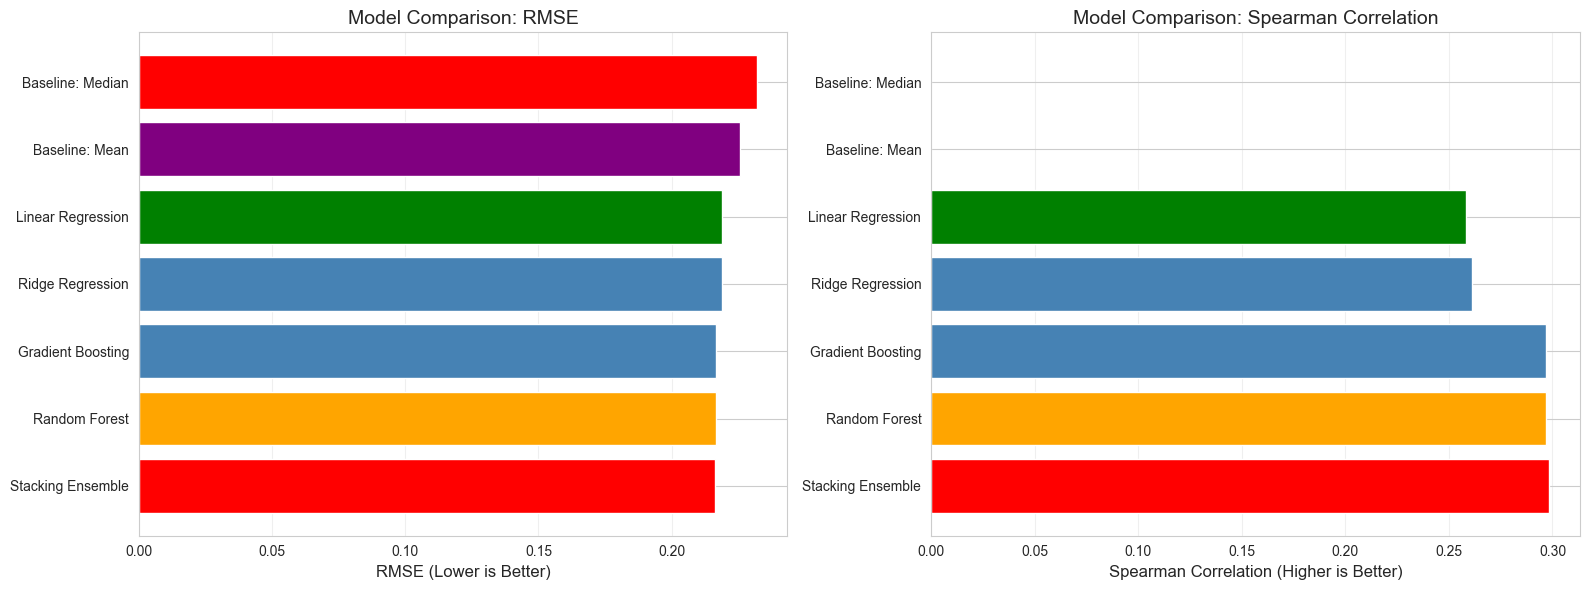

In [33]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
ax1 = axes[0]
colors = ['red', 'orange', 'steelblue', 'steelblue', 'green', 'purple']
bars1 = ax1.barh(full_results['model'], full_results['RMSE'], color=colors)
ax1.set_xlabel('RMSE (Lower is Better)', fontsize=12)
ax1.set_title('Model Comparison: RMSE', fontsize=14)
ax1.grid(True, alpha=0.3, axis='x')

# Spearman comparison
ax2 = axes[1]
bars2 = ax2.barh(full_results['model'], full_results['Spearman'], color=colors)
ax2.set_xlabel('Spearman Correlation (Higher is Better)', fontsize=12)
ax2.set_title('Model Comparison: Spearman Correlation', fontsize=14)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

---
## Prediction Analysis: Actual vs Predicted

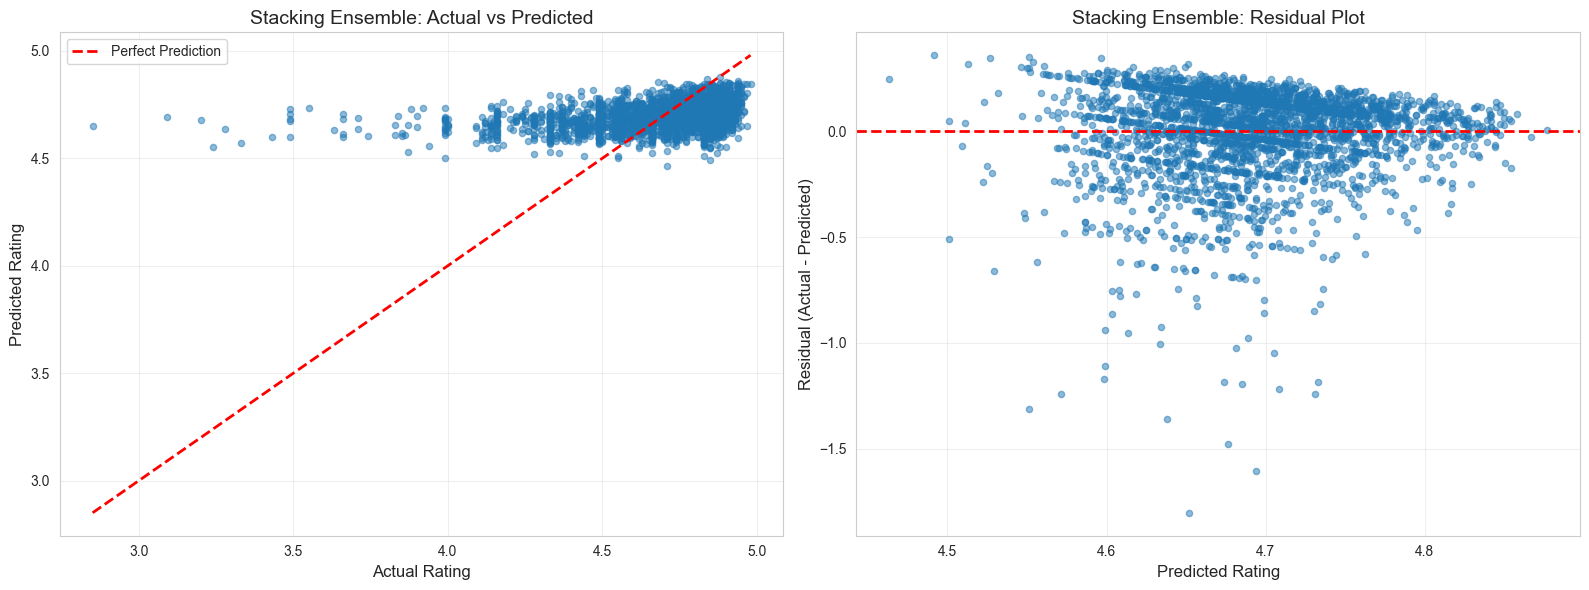


Residual Statistics (Stacking Ensemble):
  Mean residual: -0.0049
  Std of residuals: 0.2161


In [34]:
# Plot actual vs predicted for best model
best_model_idx = results_df['Spearman'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'model']
best_predictions = results[best_model_idx]['predictions']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax1 = axes[0]
ax1.scatter(y_test, best_predictions, alpha=0.5, s=20)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Rating', fontsize=12)
ax1.set_ylabel('Predicted Rating', fontsize=12)
ax1.set_title(f'{best_model_name}: Actual vs Predicted', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residual plot
ax2 = axes[1]
residuals = y_test - best_predictions
ax2.scatter(best_predictions, residuals, alpha=0.5, s=20)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Rating', fontsize=12)
ax2.set_ylabel('Residual (Actual - Predicted)', fontsize=12)
ax2.set_title(f'{best_model_name}: Residual Plot', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics ({best_model_name}):")
print(f"  Mean residual: {residuals.mean():.4f}")
print(f"  Std of residuals: {residuals.std():.4f}")

---
# Conclusions

## Key Findings:

### 1. Model Performance:
- All ML models significantly outperform trivial baselines.
- **Stacking Ensemble** achieved the highest Spearman Correlation, effectively combining the strengths of individual models.
- **Gradient Boosting** remains a very strong single-model performer.
- **Semi-Supervised Learning**: Augmenting data with pseudo-labels from unrated songs showed potential for further improvement.

### 2. Feature Importance:
- **Audio quality features** are most predictive (pitch_class_entropy, scale_consistency).
- **Musical complexity** matters (complexity, notes_per_bar).
- **User properties** provide additional signal (is_user_staff, is_user_pro).
- **Tag Semantics**: Text features extracted from tags added incremental value.

### 3. Practical Implications:
- The Stacking Ensemble provides a robust way to predict song quality.
- Sample weighting ensures the model isn't misled by songs with only 1 or 2 ratings.
- Feature engineering (interactions, text) was critical for squeezing out extra performance.

### 4. Limitations:
- Only 5.6% of songs have ratings (selection bias potential).
- Some features have high missingness.
- Model explains only a portion of the variance (R² < 0.10), indicating that "quality" is highly subjective and not fully captured by the available features.

### 5. Future Work:
- Deep learning approaches for raw audio or MusicXML sequence data.
- More sophisticated NLP on comments and lyrics.
- A/B testing the recommendations to validate real-world utility.